In [18]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage

In [19]:
import os
from dotenv import load_dotenv

In [20]:
load_dotenv()
CHAT_LLAMA = os.getenv("CHAT_LLAMA")

In [21]:
model = ChatGroq(model=CHAT_LLAMA)

In [22]:
class State(MessagesState):
    """State maintainer for summary and messages"""
    summary: str

In [ ]:
def conversation(state:State):
    
    summary = state.get('summary')
    
    if summary:
        system_message = f"The following is the summary of our conversation so far: {summary}."
        messages = [SystemMessage(content=system_message)+state['messages']]
    else:
        messages = state['messages']

    output = model.invoke(messages)

    return ({'messages':output})

In [24]:
def summarization(state:State):
    
    summary = state.get('summary')

    if summary:
        new_summary = f"Here the summary of our conversation so far:{summary} create the new summary using the new conversation messages above."
    else:
        new_summary = f"Create the summary of the above conversation"

    output = model.invoke(state['messages']+[SystemMessage(content=new_summary)])
    recent_messages = [RemoveMessage(m.id) for m in state['messages'][:-2]]

    return {'summary':output.content, 'messages':recent_messages}

In [25]:

def should_continue(state:State):
    
    messages = state['messages']
    if len(messages)>6:
        return "summarization"
    else:
        return END


In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [27]:
memory = MemorySaver()
builder = StateGraph(State)

builder.add_node('conversation', conversation)
builder.add_node('summarization', summarization)

builder.add_edge(START,'conversation')
builder.add_conditional_edges('conversation',should_continue)
builder.add_edge('summarization',END)

graph = builder.compile(checkpointer=memory)

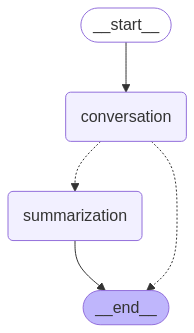

In [28]:
graph

In [29]:

# Start conversation
config={'configurable':{'thread_id':'thread1'}}
input_message = HumanMessage(content="hi! I'm Mark")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()



================================ Human Message =================================

Nice to meet you, Mark! How's it going?


In [30]:
input_message = HumanMessage(content="Im doing fine how about you?")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

It seems like you're just keeping the conversation going. That's perfectly fine! I'm happy to chat with you. Is there something specific you'd like to talk about, or we can just keep things casual?


In [31]:
input_message = HumanMessage(content="I like cricket")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

Cricket is a great sport! It's got a huge following in many countries, especially in the Commonwealth nations. Are you a fan of a particular team or player?


In [32]:
input_message = HumanMessage(content="I am a fan of Sachin Tendulkar")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================ Human Message =================================

A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in cricket history. His career spanned over two decades, and he's still revered by fans around the world. What is it about Sachin that you admire the most - his technique, his records, or something else?


In [33]:
output

{'messages': [HumanMessage(content='I am a fan of Sachin Tendulkar', additional_kwargs={}, response_metadata={}, id='00ecdf1e-cab0-472c-8d7f-8a85dce775b8'),
  HumanMessage(content="A legendary choice! Sachin Tendulkar is widely regarded as one of the greatest batsmen in cricket history. His career spanned over two decades, and he's still revered by fans around the world. What is it about Sachin that you admire the most - his technique, his records, or something else?", additional_kwargs={}, response_metadata={}, id='bb2aa3ec-f253-4003-8eb9-7eb9749132fc')],
 'summary': "## Conversation Summary \n\n### Initial Greeting \nThe conversation started with a greeting where Mark introduced himself, and the other person welcomed him and inquired about his well-being.\n\n### Casual Conversation \nMark responded that he was doing fine, and the conversation continued in a casual tone, with the other person expressing happiness to chat and asking if Mark wanted to discuss something specific or keep 